In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import quaternion
import torch
import torch.nn as nn
from torch.distributions import Categorical
import habitat

import gym
from gym.spaces import Discrete, Box, Tuple
from slam_agent import ORBSLAM2Agent, config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
class Memory:
    def __init__(self):
        self.actions = []
        self.map_states = []
        self.coord_states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    
    def clear_memory(self):
        del self.actions[:]
        del self.map_states[:]
        del self.coord_states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

        
class MyFeatureExtractor(nn.Module):
    
    def __init__(self, features_dim: int = 256):
        super(MyFeatureExtractor, self).__init__()
        self.cnn = nn.Sequential(nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=0),
                                 
                                 nn.MaxPool2d(2),
                                 nn.ReLU(),
                                 nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=0),
                                 nn.MaxPool2d(2), 
                                 nn.ReLU(),
                                 nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=0),
                                 nn.ReLU(),
                                 nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0),
                                 nn.ReLU(),
                                 nn.AdaptiveAvgPool2d((1, 1)))  # b, 256, 1, 1
        self.features_dim = features_dim
        self.linear = nn.Sequential(nn.Linear(256 + 8, features_dim), nn.ReLU())
    
    def forward(self, coord_state, map_state):
        map_features = self.cnn(map_state).reshape(-1, 256)
        return self.linear(torch.cat([map_features, coord_state], dim=1))
        
        
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, n_latent_var):
        super(ActorCritic, self).__init__()

        # shared layers
        self.feature_layer = MyFeatureExtractor()
        
        # actor
        self.action_layer = nn.Sequential(
                nn.Linear(state_dim, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, action_dim),
                nn.Softmax(dim=-1)
                )
        
        # critic
        self.value_layer = nn.Sequential(
                nn.Linear(state_dim, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, 1)
                )
        
    def forward(self):
        raise NotImplementedError
        
    def act(self, state, memory):
        agent_info, map_info, goal_info, latest_map = state
        coord_state = np.concatenate([agent_info, map_info, goal_info])
        coord_state = torch.from_numpy(coord_state).float().to(device).unsqueeze(0) 
        map_state = torch.from_numpy(latest_map).float().to(device).unsqueeze(0) 
        features = self.feature_layer(coord_state, map_state)
        
        action_probs = self.action_layer(features)
        dist = Categorical(action_probs)
        action = dist.sample()
        
        memory.coord_states.append(coord_state)
        memory.map_states.append(map_state)
        memory.actions.append(action)
        memory.logprobs.append(dist.log_prob(action))
        
        return action.item()
    
    def evaluate(self, coord_state, map_state, action):
        features = self.feature_layer(coord_state, map_state)
        
        action_probs = self.action_layer(features)
        dist = Categorical(action_probs)
        
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        
        state_value = self.value_layer(features)
        
        return action_logprobs, torch.squeeze(state_value), dist_entropy
        
class PPO:
    def __init__(self, state_dim, action_dim, n_latent_var, lr, betas, gamma, K_epochs, eps_clip):
        self.lr = lr
        self.betas = betas
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.policy = ActorCritic(state_dim, action_dim, n_latent_var).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, betas=betas)
        self.policy_old = ActorCritic(state_dim, action_dim, n_latent_var).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()
    
    def update(self, memory):   
        # Monte Carlo estimate of state rewards:
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        # Normalizing the rewards:
        rewards = torch.tensor(rewards).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        
        # convert list to tensor
        old_coord_states = torch.cat(memory.coord_states, dim=0)
        old_map_states = torch.cat(memory.map_states, dim=0)
        #old_states = torch.stack(memory.states).to(device).detach()
        old_actions = torch.stack(memory.actions).to(device).detach()
        old_logprobs = torch.stack(memory.logprobs).to(device).detach()
        
        # Optimize policy for K epochs:
        for _ in range(self.K_epochs):
            # Evaluating old actions and values :
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_coord_states, 
                                                                        old_map_states, 
                                                                        old_actions)
            
            # Finding the ratio (pi_theta / pi_theta__old):
            ratios = torch.exp(logprobs - old_logprobs.detach())
                
            # Finding Surrogate Loss:
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
        
        # Copy new weights into old policy:
        self.policy_old.load_state_dict(self.policy.state_dict())
    


In [3]:
parser = argparse.ArgumentParser()
parser.add_argument(
    "--agent-type",
    default="orbslam2-rgbd",
    choices=["blind", "orbslam2-rgbd", "orbslam2-rgb-monod"],
)
parser.add_argument(
    "--task-config", type=str, default="tasks/pointnav_rgbd.yaml"
)
parser.add_argument(
    "--goal-sensor-uuid", type=str, default="pointgoal_with_gps_compass"
)
args = parser.parse_args([
    "--task-config", "../habitat-api/configs/tasks/objectnav_mp3d_fast.yaml",
    "--goal-sensor-uuid", "objectgoal"
])

global GOAL_SENSOR_UUID
GOAL_SENSOR_UUID = args.goal_sensor_uuid

agent = ORBSLAM2Agent(config.ORBSLAM2)

In [4]:
task_config = habitat.get_config(config_paths=args.task_config)
env = habitat.Env(config=task_config)

2020-06-11 19:03:57,388 Initializing dataset ObjectNav-v1
2020-06-11 19:03:57,500 initializing sim Sim-v0
I0611 19:04:02.824032 20467 simulator.py:142] Loaded navmesh /home/azav/habitat-api/data/scene_datasets/mp3d/x8F5xyUWy9e/x8F5xyUWy9e.navmesh
2020-06-11 19:04:02,828 Initializing task ObjectNav-v1


In [5]:
class LocalNav(gym.Env):
    """
    RL environment for low-level motion planning.
    """

    def __init__(self, hab_agent):
        self.ha = hab_agent
        self.action_space = Discrete(3)  # 0 = forward, 1 = turn left, 2 = turn right (habitat - 1)
        self.latest_map = None
        self.aloc = None
        self.arot = None
        self.random_goal = None  # in GPS coordinates
        self.observation_space = Tuple((Box(low=np.array([-np.inf] * 3),  # agent loc and rot
                                            high=np.array([-np.inf] * 3),
                                            dtype=np.float32),
                                        Box(low=np.array([-np.inf] * 3),  # map loc and rot
                                            high=np.array([-np.inf] * 3),
                                            dtype=np.float32),
                                        Box(low=np.array([-np.inf, -np.inf]),  # goal loc
                                            high=np.array([np.inf, np.inf]),
                                            dtype=np.float32),
                                        Box(low=0, high=1,  # SLAM obstacle map
                                            shape=(1, 400, 400),
                                            dtype=np.float32)))

    def agent_observation(self):
        """RL agent's state observation."""
        return (np.append(self.aloc, self.arot), 
                self.ha.curr_map_info, 
                self.random_goal, 
                self.latest_map[np.newaxis])
        
    def reset(self):
        """Called at the end of each episode to reset position."""
        obs = env.reset()
        self.ha.reset()
        

        # Random goal location
        rtra = env._sim.sample_navigable_point()
        rrot = quaternion.from_euler_angles(np.array([0, 0, 0]))
        obs = env._sim.get_observations_at(position=rtra, rotation=rrot, keep_agent_at_new_pose=True)
        obs = env.step(1)
        self.random_goal = obs['gps']
        
        # Random starting location
        rtra = env._sim.sample_navigable_point()
        ang = np.random.rand() * 2 * np.pi
        rrot = quaternion.from_euler_angles(np.array([0, ang, 0]))
        obs = env._sim.get_observations_at(position=rtra, rotation=rrot, keep_agent_at_new_pose=True)
        obs = env.step(1)
        self.aloc, self.arot = obs['gps'], obs['compass']
        self.ha.update_internal_state(obs)
        
        if 'numpy' in str(type(self.ha.map2DObstacles)): 
            self.latest_map = (self.ha.map2DObstacles > self.ha.obstacle_th).astype(np.uint8)
        else:
            self.latest_map = (self.ha.map2DObstacles[0,0].cpu().numpy() > self.ha.obstacle_th).astype(np.uint8)
            
        return self.agent_observation()

    def step(self, action):
        """
        MDP step.

        :param action: 0 forward, 1 turnleft, 2 turnright
        :return: state, reward, done (bool), auxiliary info
        """
        
        obs = env.step(action + 1)
        self.ha.update_internal_state(obs)
        self.aloc, self.arot = obs['gps'], obs['compass']
        
        if 'numpy' in str(type(self.ha.map2DObstacles)): 
            self.latest_map = (self.ha.map2DObstacles > self.ha.obstacle_th).astype(np.uint8)
        else:
            self.latest_map = (self.ha.map2DObstacles[0,0].cpu().numpy() > self.ha.obstacle_th).astype(np.uint8)
            
            
        reward = -1  # time-minimizing reward
        done = np.linalg.norm(self.aloc - self.random_goal) < 0.5  # reached goal
        return self.agent_observation(), reward, done, {}

0.002 (0.9, 0.999)


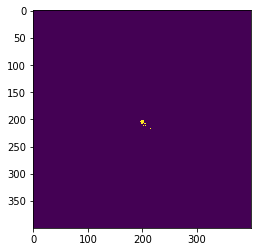

RuntimeError: CUDA out of memory. Tried to allocate 154.00 MiB (GPU 0; 31.72 GiB total capacity; 4.13 GiB already allocated; 62.38 MiB free; 29.23 MiB cached)

In [11]:
############## Hyperparameters ##############
env_name = 'localnav'
rl_env = LocalNav(agent)
state_dim = 256
action_dim = 3
render = False
solved_reward = -30         # stop training if avg_reward > solved_reward
log_interval = 20           # print avg reward in the interval
max_episodes = 50000        # max training episodes
max_timesteps = 300         # max timesteps in one episode
n_latent_var = 64           # number of variables in hidden layer
update_timestep = 128       # update policy every n timesteps
lr = 0.002
betas = (0.9, 0.999)
gamma = 0.99                # discount factor
K_epochs = 4                # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
random_seed = None
#############################################

if random_seed:
    torch.manual_seed(random_seed)
    env.seed(random_seed)

memory = Memory()
ppo = PPO(state_dim, action_dim, n_latent_var, lr, betas, gamma, K_epochs, eps_clip)
print(lr,betas)

# logging variables
running_reward = 0
avg_length = 0
timestep = 0

# training loop
for i_episode in range(1, max_episodes+1):
    state = rl_env.reset()
    for t in range(max_timesteps):
        timestep += 1

        # Running policy_old:
        action = ppo.policy_old.act(state, memory)
        state, reward, done, _ = rl_env.step(action)

        # Saving reward and is_terminal:
        memory.rewards.append(reward)
        memory.is_terminals.append(done)

        # update if its time
        if timestep % update_timestep == 0:
            ppo.update(memory)
            memory.clear_memory()
            timestep = 0

        running_reward += reward
        if render:
            rl_env.render()
        if done:
            break

    avg_length += t
    
    # logging
    if i_episode % log_interval == 0:
        # stop training if avg_reward > solved_reward
        if running_reward > (log_interval*solved_reward):
            print("########## Solved! ##########")
            torch.save(ppo.policy.state_dict(), './PPO_{}.pth'.format(env_name))
            break
        avg_length = int(avg_length/log_interval)
        running_reward = int((running_reward/log_interval))

        print('Episode {} \t avg length: {} \t reward: {}'.format(i_episode, avg_length, running_reward))
        running_reward = 0
        avg_length = 0